# 使用 Pyro 搭建因果模型

本教程将展示使用 Pyro 搭建信息因果模型的一般步骤。

Pyro is a deep probabilistic programming language(PPL) released by Uber AI Labs. Pyro is built on top of PyTorch and is based on four fundamental principles:

- **Universal**: Pyro is a universal PPL — it can represent any computable probability distribution. How? By starting from a universal language with iteration and recursion (arbitrary Python code), and then adding random sampling, observation, and inference.
- **Scalable:** Pyro scales to large data sets with little overhead above hand-written code. How? By building modern black box optimization techniques, which use mini-batches of data, to approximate inference.
- **Minimal:** Pyro is agile and maintainable. How? Pyro is implemented with a small core of powerful, composable abstractions. Wherever possible, the heavy lifting is delegated to PyTorch and other libraries.
- **Flexible:** Pyro aims for automation when you want it and control when you need it. How? Pyro uses high-level abstractions to express generative and inference models, while allowing experts to easily customize inference.


相关资料包括：

- [Pyro 官网](https://pyro.ai)
- [Pyro 全面介绍](https://sites.google.com/view/causal-inference-zerotoall/codes/tools/pyro)
- [Pyro 官方教程汉化版](https://causalai.github.io/pyro_zh_tutorial/)

## 称重例子

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
pyro.set_rng_seed(101)
mu = 8.5

def scale(mu):
    weight = pyro.sample("weight", dist.Normal(mu, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

def scale_parametrized_guide(mu):
    a = pyro.param("a", torch.tensor(mu))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

pyro.clear_param_store()

with pyro.poutine.trace(param_only=True) as param_capture:
    loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
    loss.backward()
params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

def step(params):
    for x in params:
        x.data = x.data - lr * x.grad
        x.grad.zero_()

print("Before updated:", pyro.param('a'), pyro.param('b'))
losses, a,b  = [], [], []
lr = 0.001
num_steps = 1000
for t in range(num_steps):
    with pyro.poutine.trace(param_only=True) as param_capture:
        loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
        loss.backward()
        losses.append(loss.data)
    params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    step(params)
print("After updated:", pyro.param('a'), pyro.param('b'))


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

Before updated: tensor(8.5000, requires_grad=True) tensor(1., requires_grad=True)
After updated: tensor(9.0979, requires_grad=True) tensor(0.6203, requires_grad=True)
a =  9.097911834716797
b =  0.6202840209007263


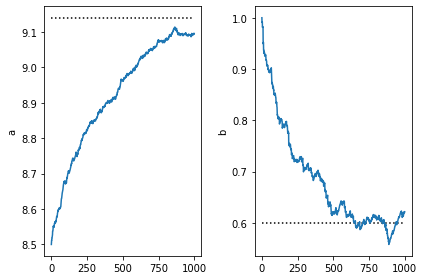

In [3]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

## 掷硬币例子

硬币的先验分布是 $\beta(10, 10)$ 得到若干数据之后的后验分布是多少？

In [1]:
import math, os, torch, pyro
import torch.distributions.constraints as constraints
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)
pyro.clear_param_store()

data = []
data.extend([torch.tensor(1.0) for _ in range(6)])
data.extend([torch.tensor(0.0) for _ in range(4)])

def model(data):
    alpha0, beta0 = torch.tensor(10.0), torch.tensor(10.0)
    theta = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i])
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


....................
based on the data and our prior belief, the fairness of the coin is 0.534 +- 0.089
